# Trabalho Prático 1 - Introdução à Inteligência Artificial - DCC642

### 0 - Informações básicas


- Tema: Agentes conversacionais de busca
- Professora: Gisele L. Pappa
- Aluna: Carla Beatriz Ferreira
- Data: 18/05//2025
- Valor: 15 pontos
- Documentação disponível em https://docs.google.com/document/d/1otLG8l551rNKOhsFqHR0AGeyiCqThphwiAW5-ELpzxo/edit?usp=sharing

### 1 - Configurações iniciais e impressão de dados sobre o grafo obtido

In [1]:
!pip install scikit-learn osmnx pandas matplotlib smolagents[litellm] networkx


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from smolagents import tool, CodeAgent, LiteLLMModel, Tool, InferenceClientModel, FinalAnswerTool

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Tal qual tutorial do Hugging Face
# from smolagents import LiteLLMModel

model = LiteLLMModel(
    model_id="ollama_chat/qwen3:8b",  # Alterado!
    api_base="http://127.0.0.1:11434",  # Default Ollama local server
    num_ctx=8192,
)

In [4]:
# G = ox.graph.graph_from_place(
#     "belo horizonte - MG", 
#     network_type="walk",
#     custom_filter='["highway"~"primary|secondary|tertiary"]'
# )
# place = "Belo Horizonte, Minas Gerais, Brazil"
# ox.save_graphml(G, filepath="bh.graphml")

# Carregando o grafo a partir do arquivo .graphml
G = ox.load_graphml("bh.graphml")
place = "Belo Horizonte, Minas Gerais, Brazil"

In [5]:
# Associa os museus aos nós do grafo
features = ox.features.features_from_place(place, {"tourism": "museum"})
feature_points = features.representative_point()
nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)

useful_tags = ["name", "fee"]  # Ajuste com base nas colunas disponíveis
for node, feature in zip(nn, features[useful_tags].to_dict(orient="records")):
    feature = {k: v for k, v in feature.items() if pd.notna(v)}
    G.nodes[node].update({"museum": feature})

In [6]:
# print(features.columns)

In [7]:
# Verifica se os museus foram associados corretamente
print(f"Quantidade de nós no grafo: {len(G.nodes)}")
print(f"Quantidade de arestas no grafo: {len(G.edges)}")
print(f"Quantidade de nós com museus: {len([n for n, d in G.nodes(data=True) if 'museum' in d])}")

Quantidade de nós no grafo: 3834
Quantidade de arestas no grafo: 11668
Quantidade de nós com museus: 14


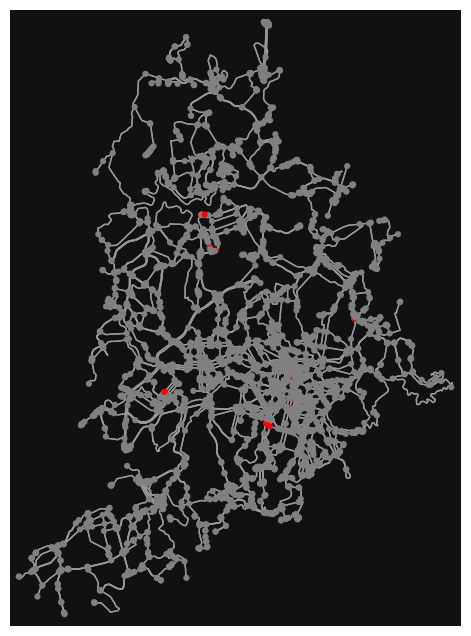

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# Identifica os nós que possuem a chave "museum"
museum_nodes = [n for n, d in G.nodes(data=True) if "museum" in d]

# Define as cores dos nós: vermelho para nós com "museum", cinza para os demais
node_colors = ["r" if n in museum_nodes else "gray" for n in G.nodes]

# Plota o grafo com as cores ajustadas
# ox.plot_graph(G, node_color=node_colors, node_size=10, edge_color="k", bgcolor="w", show=False)

# plota o grafo como no enunciado
# ox.plot_graph(G)

# Plota o grafo com os nós de museus em vermelho
node_colors = ["red" if "museum" in data else "gray" for _, data in G.nodes(data=True)]
ox.plot_graph(G, node_color=node_colors, node_size=20)

In [9]:
# Imprime os museus
for node, data in G.nodes(data=True):
    if "museum" in data:
        print(f"Node {node}: {data['museum']['name']}")

Node 27591003: Casa Kubitschek
Node 29095351: Museu de História Natural da UFMG
Node 29096783: Museu Mineiro
Node 32448895: Centro de Arte Contemporânea e Fotografia
Node 32600635: Museu de Artes e Ofícios
Node 35968129: Espaço do Conhecimento UFMG
Node 36417185: Museu da Imagem e do Som
Node 351980159: Museu de Ciências Morfológicas da UFMG
Node 1034410884: Museu de Arte da Pampulha
Node 2285761096: Museu Brasileiro do Futebol
Node 2460331365: Casarão histórico do Museu Histórico Abílio Barreto
Node 2823629282: Edificio Sede MHAB
Node 5395802458: Memorial Minas Gerais Vale
Node 8201639218: Museu de Ciências Naturais - Prédio 40


In [10]:
# imprime os museus e as ruas conectadas ao nó
for node, data in G.nodes(data=True):
    if "museum" in data:
        name = data["museum"].get("name", "Sem nome")
        ruas = set()
        for _, _, edge_data in G.edges(node, data=True):
            rua = edge_data.get("name")
            if isinstance(rua, list):
                ruas.update(rua)
            elif rua:
                ruas.add(rua)
        if ruas:
            ruas_str = " com ".join(ruas)
        else:
            ruas_str = "Rua não informada"
        print(f"- {name}: {ruas_str}")

- Casa Kubitschek: Avenida Otacílio Negrão de Lima
- Museu de História Natural da UFMG: Avenida Contagem com Rua Gustavo da Silveira
- Museu Mineiro: Rua dos Timbiras com Avenida João Pinheiro
- Centro de Arte Contemporânea e Fotografia: Avenida Amazonas com Avenida Afonso Pena
- Museu de Artes e Ofícios: Rua dos Guaicurus com Avenida dos Andradas
- Espaço do Conhecimento UFMG: Avenida Bias Fortes com Rua da Bahia
- Museu da Imagem e do Som: Rua dos Timbiras com Avenida Álvares Cabral
- Museu de Ciências Morfológicas da UFMG: Avenida Presidente Carlos Luz com Avenida Rei Pelé
- Museu de Arte da Pampulha: Avenida Otacílio Negrão de Lima
- Museu Brasileiro do Futebol: Avenida Coronel Oscar Paschoal
- Casarão histórico do Museu Histórico Abílio Barreto: Rua Conde de Linhares
- Edificio Sede MHAB: Avenida Prudente de Morais com Rua Tenente Renato César
- Memorial Minas Gerais Vale: Praça da Liberdade com Rua Gonçalves Dias
- Museu de Ciências Naturais - Prédio 40: Avenida Dom José Gaspar


### 2 - Algoritmos de busca

usando a biblioteca networkx 
- A mesma já possui funções como bfs_edges(), dfs_edges(), dijkstra_path() e astar_path()

Referências:
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html#networkx.algorithms.shortest_paths.weighted.dijkstra_path
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path 

In [11]:
# Custo uniforme / Dijkstra no grafo utilizando networkx
# Comentários em inglês para manter a consistência com o código original e melhor entendimento do agente

@tool
def path_with_dijkstra(
    start: str, 
    end: str, 
    G: nx.MultiDiGraph, 
    # weight: str = "length"
) -> list:
    """
    Find the shortest path between two nodes using Dijkstra's algorithm.
    
    Args:
        start (str): ID from the start node.
        end (str): ID from the end node.
        G (ox.Graph): Graph to be used.
        weight (str): Atribut to be used as weight on the edges. Default is "length".
    
    Returns:
        list: List of nodes representing the shortest path. If the path is not found, returns an empty list.
    """
    return nx.dijkstra_path(G, start, end)

In [12]:
# Definição da Heuristica para o A* como sendo o trajeto em linha reta
def heuristic(a, b):
    """
    Heuristic function for A* algorithm. It calculates the straight-line distance between two nodes.
    
    Args:
        a (str): ID from the start node.
        b (str): ID from the end node.
    
    Returns:
        float: Straight-line distance between nodes a and b.
    """
    return ox.distance.euclidean_dist_vec(
        G.nodes[a]["y"], G.nodes[a]["x"], G.nodes[b]["y"], G.nodes[b]["x"]
    )

# Algoritimo A* utilizando networkx
@tool
def path_with_astar(
    start: str, 
    end: str, 
    G: nx.MultiDiGraph, 
    # weight: str = "length"
) -> list:
    """
    Find the shortest path between two nodes using A* algorithm.
    
    Args:
        start (str): ID from the start node.
        end (str): ID from the end node.
        G (ox.Graph): Graph to be used.
        weight (str): Atribut to be used as weight on the edges. Default is "length".
    
    Returns:
        list: List of nodes representing the shortest path. If the path is not found, returns an empty list.
    """
    return nx.astar_path(G, start, end, heuristic=heuristic)

### 3 - Exemplo de conexão do agente com nosso código e LLM Ollama
Essa seção apenas apresenta código comentado que foi utilizado como base para a construção dessa atividade.

Em cada parte listada há a fonte de onde foi retirado. Dessa forma, as celulas abaixo podem ser desconsideradas para a avaliação final considerando apenas a documentação e as referências.

#### 3.1 - Uso tal qual no exemplo do vídeo do (monitor) Matheus C. Teixeira
- em https://www.youtube.com/watch?v=5PgA2StGntQ

In [13]:
# from smolagents import CodeAgent, LiteLLMModel, Tool, InferenceClientModel, FinalAnswerTool

# class FindRoutTool(Tool):
#     name = "find_route"
#     description = """
#     This tool must be used when you want to find the route or path between two places, locations or points
#     """
#     inputs = {
#         "source": {
#             "type": "string",
#             "description": "The source location. It can be an address, a place, a street name, etc.",
#         },
#         "target": {
#             "type": "string",
#             "description": "The target location. It can be an address, a place, a street name, etc.",
#         },
#     }
#     output_type = "string"

#     def forward(self, source, target):
#         return f"The sortest route from {source} to {target} is ..." #chamar a função de rota aqui
    
# model = LiteLLMModel(
#     model_id="ollama_chat/qwen3:8b",  # Or try other Ollama-supported models
#     api_base="http://localhost:11434",  # Default Ollama local server
#     num_ctx=8192,
# )

# agent = CodeAgent(tools=[FindRoutTool()], model=model, add_base_tools=False)
# agent.run("How can I go from Margô Drinkeria to Serilla Cozinha & Drinks?") #prompt a ser alterado para exemplos

#### 3.2 - Exemplo de Prompt do curso do HF
- em https://huggingface.co/learn/agents-course/unit1/dummy-agent-library

In [14]:
# # This system prompt is a bit more complex and actually contains the function description already appended.
# # Here we suppose that the textual description of the tools has already been appended.

# SYSTEM_PROMPT = """Answer the following questions as best you can. You have access to the following tools:

# get_weather: Get the current weather in a given location

# The way you use the tools is by specifying a json blob.
# Specifically, this json should have an `action` key (with the name of the tool to use) and an `action_input` key (with the input to the tool going here).

# The only values that should be in the "action" field are:
# get_weather: Get the current weather in a given location, args: {"location": {"type": "string"}}
# example use :

# {{
#   "action": "get_weather",
#   "action_input": {"location": "New York"}
# }}


# ALWAYS use the following format:

# Question: the input question you must answer
# Thought: you should always think about one action to take. Only one action at a time in this format:
# Action:

# $JSON_BLOB (inside markdown cell)

# Observation: the result of the action. This Observation is unique, complete, and the source of truth.
# ... (this Thought/Action/Observation can repeat N times, you should take several steps when needed. The $JSON_BLOB must be formatted as markdown and only use a SINGLE action at a time.)

# You must always end your output with the following format:

# Thought: I now know the final answer
# Final Answer: the final answer to the original input question

# Now begin! Reminder to ALWAYS use the exact characters `Final Answer:` when you provide a definitive answer. """

In [15]:
# # Since we are running the “text_generation” method, we need to apply the prompt manually:
# prompt=f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
# {SYSTEM_PROMPT}
# <|eot_id|><|start_header_id|>user<|end_header_id|>
# What's the weather in London ?
# <|eot_id|><|start_header_id|>assistant<|end_header_id|>
# """

# # We can also do it like this, which is what happens inside the chat method :
# messages=[
#     {"role": "system", "content": SYSTEM_PROMPT},
#     {"role": "user", "content": "What's the weather in London ?"},
#     ]
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.3-70B-Instruct")

# tokenizer.apply_chat_template(messages, tokenize=False,add_generation_prompt=True)

### 4 - Definições necessárias para o agente
Informações sobre o que ele pode usar, como mostrar a resposta final etc.

Opção utilizando @Tools

In [16]:
# Problema: O agente não tem o direcionamento de qual função usar, então ele não consegue fazer a chamada correta.
# agent = CodeAgent(
#     tools=[
#         Tool(
#             name="path_with_dijkstra",
#             func=path_with_dijkstra,
#             description="Find the shortest path between two nodes using Dijkstra's algorithm.",
#         ),
#         Tool(
#             name="path_with_astar",
#             func=path_with_astar,
#             description="Find the shortest path between two nodes using A* algorithm.",
#         ),
#     ],
#     model=model,
#     add_base_tools=False,
# )

Opção utilizando uma classe FindRoutTool tal qual exemplo 1

In [26]:
def get_node_by_museum_name(G, museum_name):
    for node, data in G.nodes(data=True):
        if "museum" in data and data["museum"].get("name") == museum_name:
            return node
    raise ValueError(f"Museu '{museum_name}' não encontrado no grafo.")

class FindRoutTool(Tool):
    name = "find_route"
    description = """
    This tool must be used when you want to find the route or path between two places, locations or points
    """
    inputs = {
        "source": {
            "type": "string",
            "description": "The source location (museum name).",
        },
        "target": {
            "type": "string",
            "description": "The target location (museum name).",
        },
    }
    output_type = "string"

    def __init__(self, G):
        super().__init__()
        self.G = G

    def get_node_by_museum_name(self, museum_name):
        for node, data in self.G.nodes(data=True):
            if "museum" in data and data["museum"].get("name") == museum_name:
                return node
        raise ValueError(f"Museu '{museum_name}' não encontrado no grafo.")

    def forward(self, source, target):
        source_node = self.get_node_by_museum_name(source)
        target_node = self.get_node_by_museum_name(target)
        path = path_with_dijkstra(source_node, target_node, self.G)
        return f"The shortest route from {source} to {target} is {path} and has {len(path)} nodes."
  
model = LiteLLMModel(
    model_id="ollama_chat/qwen3:8b",  # Or try other Ollama-supported models
    api_base="http://localhost:11434",  # Default Ollama local server
    num_ctx=8192,
)

agent = CodeAgent(tools=[FindRoutTool(G)], model=model, add_base_tools=False)

### 5 - Execução do agente
A partir do texto do "usuário" (modificando o código)

In [18]:
# Museus utilizados para os testes e avaliações
m1 = "Museu de História Natural da UFMG"
m2 = "Museu de Ciências Morfológicas da UFMG"
m3 = "Centro de Arte Contemporânea e Fotografia"
m4 = "Museu da Imagem e do Som"
m5 = "Museu de Arte da Pampulha"

# print(f"How can I go from {m1} to {m2}?")

Teste sem agente, apenas utilizando as funções já definidas:

In [24]:
# Exemplo de uso:
source_node = get_node_by_museum_name(G, m1)
target_node = get_node_by_museum_name(G, m2)
route = path_with_dijkstra(source_node, target_node, G)
print(route)

[29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 351980331, 2965169479, 351980159]


In [27]:
agent.run(f"How can I go from {m1} to {m2}") #prompt a ser alterado para exemplos

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Museu de História Natural da UFMG", target="Museu de Ciências Morfológicas da UFMG")  
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da 
UFMG is [29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 
5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 
2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 
31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 351980331, 2965169479, 351980159] and has 38 nodes.

[Step 1: Duration 106.67 seconds| Input tokens: 2,081 | Output tokens: 383]

'The shortest route from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG is [29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 351980331, 2965169479, 351980159] and has 38 nodes.'

In [21]:
# Alternativa:
# user_input = "How can I go from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG?"
# agent.run(user_input)

# ou ainda
# source_input = input("Qual seu ponto de partida (nome do museu)? ")
# target_input = input("Qual seu ponto de chegada (nome do museu)? ")
# agent.run(f"How can I go from {source_input} to {target_input}?")

### 6 - Comparação e análise de resultados

Testes Realizados:
1. De: Museu de História Natural da UFMG, Para: Museu de Ciências Morfológicas da UFMG (1 para 2)
2. De: Centro de Arte Contemporânea e Fotografia, Para: Museu da Imagem e do Som (3 para 4)
3. De: Museu de Ciências Morfológicas da UFMG, Para: Museu de Arte da Pampulha (2 para 5)
